In [ ]:
import os
import sys
import pickle

import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

sys.path.append('code')
sys.path.append('/jet/home/azhang19/stat 214/stat-214-lab3-group6/code')

import word_embedding # Imports the classes defined above if they are in word_embedding.py

# Define the base path for data access
data_path = '/ocean/projects/mth240012p/shared/data' # Path where data files are stored

In [4]:
# %% Define training set size proportion
train_size = 0.75

In [5]:
# %% Load preprocessed word sequences (likely includes words and their timings)
with open(f'{data_path}/raw_text.pkl', 'rb') as file:
    wordseqs = pickle.load(file) # wordseqs is expected to be a dictionary: {story_id: WordSequenceObject}

# %% Get list of story identifiers and split into training and testing sets
# Assumes story data for 'subject2' exists and filenames are story IDs + '.npy'
stories = [i[:-4] for i in os.listdir(f'{data_path}/subject2')] # Extract story IDs from filenames
# Split stories into train and test sets with a fixed random state for reproducibility
train, test = train_test_split(stories, train_size=train_size, random_state=4193332621)

#train, test = train[:10], test[:10] # For testing purposes, limit to first 10 stories in each set

/var/tmp/ipykernel_24068/4207588195.py:3: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  wordseqs = pickle.load(file) # wordseqs is expected to be a dictionary: {story_id: WordSequenceObject}


In [6]:
# %% Bag-of-Words (BoW) Feature Engineering Pipeline

# 1. Fit BoW model on training data texts
# Extracts vocabulary based on words appearing > 1 time in the training stories
bow_model = word_embedding.BagofWords().fit([wordseqs[story].data for story in train])

# 2. Create an aggregator for BoW features
# Applies delays 1-4, standardizes, and trims first 5 and last 10 TRs
bow_aggregator = word_embedding.embeddings_aggregator(delays=range(1, 5), standardize=True, trim_range=(5, -10))

# 3. Generate downsampled BoW embeddings for all stories (train + test)
# Transforms words to one-hot vectors using bow_model, then aligns to TR timing
bow_embedding = word_embedding.embed_sentences(train + test, wordseqs, bow_model)

# 4. Aggregate, delay, standardize, and trim BoW embeddings for train/test sets
# Fit the aggregator (scaler) on training data and transform training data
X_train_bow = bow_aggregator.fit_transform(train, bow_embedding)
# Transform test data using the aggregator fitted on training data
X_test_bow = bow_aggregator.transform(test, bow_embedding)

In [7]:
# %% Word2Vec Feature Engineering Pipeline

# 1. Load pre-trained Word2Vec model
w2v_model_path = '/jet/home/azhang19/stat 214/stat-214-lab3-group6/data/word2vec' # Path to Word2Vec model
w2v_model = word_embedding.StaticVectorsModel(w2v_model_path) # Initialize wrapper

# 2. Create an aggregator for Word2Vec features (same settings as BoW)
w2v_aggregator = word_embedding.embeddings_aggregator(delays=range(1, 5), standardize=True, trim_range=(5, -10))

# 3. Generate downsampled Word2Vec embeddings for all stories
# Transforms words to Word2Vec vectors, then aligns to TR timing
w2v_embedding = word_embedding.embed_sentences(train + test, wordseqs, w2v_model)

# 4. Aggregate, delay, standardize, and trim Word2Vec embeddings for train/test sets
# Fit aggregator (scaler) and transform training data
X_train_w2v = w2v_aggregator.fit_transform(train, w2v_embedding)
# Transform test data using the fitted aggregator
X_test_w2v = w2v_aggregator.transform(test, w2v_embedding)

In [8]:
# %% GloVe Feature Engineering Pipeline

# 1. Load pre-trained GloVe model
glove_model_path = '/jet/home/azhang19/stat 214/stat-214-lab3-group6/data/glove-6B' # Path to GloVe model
glove_model = word_embedding.StaticVectorsModel(glove_model_path) # Initialize wrapper

# 2. Create an aggregator for GloVe features (same settings as BoW/Word2Vec)
glove_aggregator = word_embedding.embeddings_aggregator(delays=range(1, 5), standardize=True, trim_range=(5, -10))

# 3. Generate downsampled GloVe embeddings for all stories
# Transforms words to GloVe vectors, then aligns to TR timing
glove_embedding = word_embedding.embed_sentences(train + test, wordseqs, glove_model)

# 4. Aggregate, delay, standardize, and trim GloVe embeddings for train/test sets
# Fit aggregator (scaler) and transform training data
X_train_glove = glove_aggregator.fit_transform(train, glove_embedding)
# Transform test data using the fitted aggregator
X_test_glove = glove_aggregator.transform(test, glove_embedding)

In [9]:
# %% Define a function to load fMRI data for specified stories and subjects
def load_fmri_data(stories, data_path):
    """
    Loads fMRI data (.npy files) for given stories and subjects.

    Args:
        stories (list): List of story identifiers to load fMRI data for.
        data_path (str): Base path where subject fMRI data is stored (e.g., data_path/subject_id/story_id.npy).

    Returns:
        dict: A nested dictionary `{subject_id: {story_id: fmri_data_array}}`.
    """
    subjects = ['subject2', 'subject3'] # List of subjects to load data for
    fmri_data = {} # Outer dictionary {subject: {story: data}}
    for subject in subjects:
        subject_dict = {} # Inner dictionary {story: data} for the current subject
        for story in stories:
            # Construct the full path to the fMRI data file
            file_path = os.path.join(data_path, subject, f'{story}.npy')
            # Load the NumPy array from the file
            data = np.load(file_path)
            subject_dict[story] = data # Store data in the inner dictionary
        fmri_data[subject] = subject_dict # Store the subject's data dictionary
    return fmri_data

In [10]:
fmri_data = load_fmri_data(train + test, data_path)

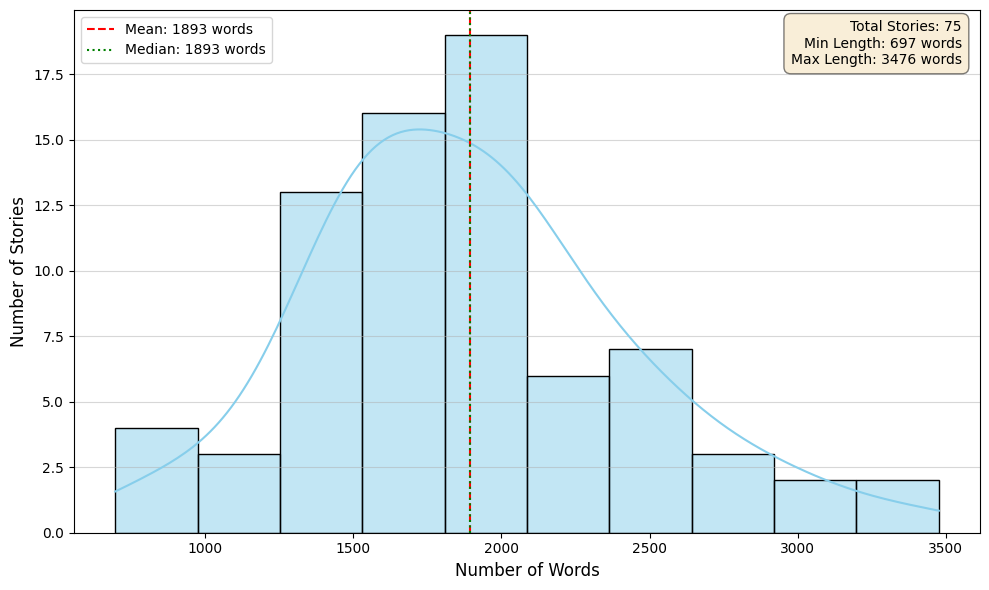

In [11]:
stories_len = [len(wordseqs[i].data) for i in train]

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Assume you have your stories_len list already populated, e.g.:
# stories_len = [1500, 2100, 950, 3500, 1800, 2500, 1200, 4000, 500, 2000, 2800]
# (Replace this with your actual stories_len data)

# --- Calculate Summary Statistics ---
mean_len = np.mean(stories_len)
median_len = np.median(stories_len)
min_len = np.min(stories_len)
max_len = np.max(stories_len)
num_stories = len(stories_len)

# --- Create the Plot ---

plt.figure(figsize=(10, 6)) # Adjust figure size for better readability

# Create a histogram with KDE overlay
# 'bins' can be an integer or 'auto' to let seaborn decide
sns.histplot(stories_len, kde=True, bins='auto', color='skyblue')

# Add vertical lines for Mean and Median
plt.axvline(mean_len, color='red', linestyle='--', linewidth=1.5, label=f'Mean: {mean_len:.0f} words')
plt.axvline(median_len, color='green', linestyle=':', linewidth=1.5, label=f'Median: {median_len:.0f} words')

# Add labels and title
#plt.title('Distribution of Story Lengths (Number of Words)', fontsize=14)
plt.xlabel('Number of Words', fontsize=12)
plt.ylabel('Number of Stories', fontsize=12)
plt.legend()

# Add text box with more statistics (optional, but informative)
stats_text = f'Total Stories: {num_stories}\nMin Length: {min_len} words\nMax Length: {max_len} words'
plt.text(0.98, 0.98, stats_text, transform=plt.gca().transAxes,
         verticalalignment='top', horizontalalignment='right',
         bbox=dict(boxstyle='round,pad=0.5', fc='wheat', alpha=0.5),
         fontsize=10)

plt.grid(axis='y', alpha=0.5) # Add horizontal grid lines for better readability
plt.tight_layout() # Adjust layout to prevent labels overlapping
plt.savefig('story_length_distribution.pdf', bbox_inches='tight') # Save the figure
plt.show()


In [12]:
def get_fmri_data(stories, fmri_data):
    """
    Concatenates fMRI data across a list of stories for each subject.

    Args:
        stories (list): List of story identifiers to concatenate data for.
        fmri_data (dict): The nested dictionary loaded by `load_fmri_data`.

    Returns:
        dict: A dictionary `{subject_id: concatenated_fmri_data_array}`, where
              the array contains fMRI data for the specified stories concatenated
              along the time axis (axis 0).
    """
    result = {} # Dictionary to store concatenated data per subject
    subjects = list(fmri_data.keys()) # Get list of subjects from the loaded data
    for subject in subjects:
        y = [] # List to hold fMRI data arrays for stories for the current subject
        for story in stories:
            # Append the fMRI data for the current story and subject
            y.append(fmri_data[subject][story])
        # Concatenate along the time axis (axis 0)
        y = np.concatenate(y, axis=0)
        result[subject] = y # Store concatenated data for the subject
    return result

fmri_train = get_fmri_data(train, fmri_data)

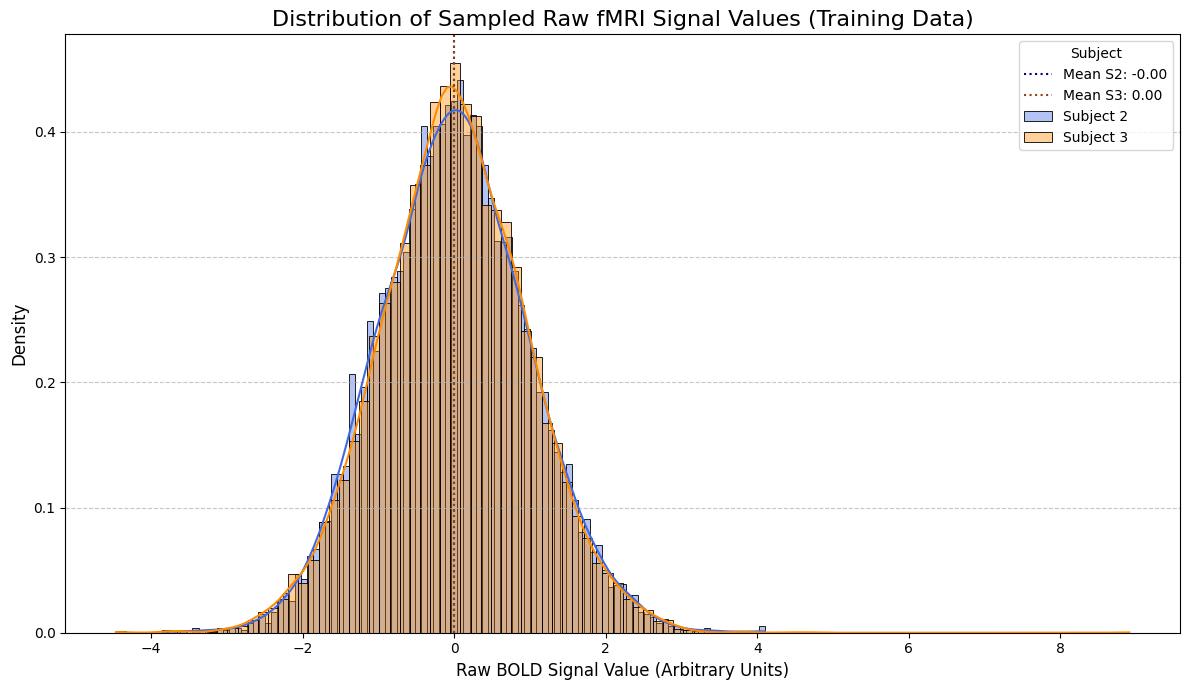

In [13]:
fmri_dist_subject2 = np.random.choice(fmri_train["subject2"].flatten(), 10000, replace=False)
fmri_dist_subject3 = np.random.choice(fmri_train["subject3"].flatten(), 10000, replace=False)

# --- Create the Plot ---
plt.figure(figsize=(12, 7)) # Adjust size for better readability

# Plot histograms with KDE overlay for both subjects
# Using stat='density' normalizes histograms for better comparison of shape
sns.histplot(fmri_dist_subject2, bins=100, kde=True, color='royalblue', label='Subject 2', alpha=0.4, stat='density')
sns.histplot(fmri_dist_subject3, bins=100, kde=True, color='darkorange', label='Subject 3', alpha=0.4, stat='density')

# --- Add Labels and Title ---
plt.title('Distribution of Sampled Raw fMRI Signal Values (Training Data)', fontsize=16)
plt.xlabel('Raw BOLD Signal Value (Arbitrary Units)', fontsize=12)
plt.ylabel('Density', fontsize=12) # Y-axis shows density due to stat='density'

# --- Add Legend and Grid ---
plt.legend(title='Subject')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# --- Optional: Add Mean/Median lines ---
mean_s2 = np.mean(fmri_dist_subject2)
mean_s3 = np.mean(fmri_dist_subject3)
plt.axvline(mean_s2, color='navy', linestyle=':', linewidth=1.5, label=f'Mean S2: {mean_s2:.2f}')
plt.axvline(mean_s3, color='saddlebrown', linestyle=':', linewidth=1.5, label=f'Mean S3: {mean_s3:.2f}')
plt.legend(title='Subject') # Update legend to include means if added

# --- Final Touches ---
plt.tight_layout() # Adjust layout
plt.savefig('fmri_signal_distribution.pdf', bbox_inches='tight') # Save the figure
plt.show()